In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

import utils
import scoring

import os
import tempfile
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

EPOCHS = 1000
BATCH_SIZE = 32
SHUFFLE = True
REPEATITION=50


log_dir = "./logs/fit_100percent_Data/"

#output folder for saving checkpoint
outputFolder = './output_100percent_Data'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
    
%load_ext tensorboard
!rm -rf log_dir

2.2.0


In [2]:
columns = utils.SIMPLE_FEATURE_COLUMNS + ["id", "label", "weight"] #, "sWeight", "kinWeight"]
DATA_PATH = "~/share/data/I-coopetition-muon-id/"
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv.gz"), index_col="id", usecols=columns)
test_df = pd.read_csv(os.path.join(DATA_PATH, "test-features.csv.gz"), index_col="id", usecols=utils.SIMPLE_FEATURE_COLUMNS + ["id"])


# columns = utils.SIMPLE_FEATURE_COLUMNS + ["id", "label", "weight"] #,  "kinWeight"]
# DATA_FOLDER = "~/share/data/1.6.2-boosting/"
# data = pd.read_csv(os.path.join(DATA_FOLDER, "train_1_percent.csv"), index_col="id", usecols=columns)


# new_key_label=[]
# for name in data.columns:
#     if '[' in name:
#         name = name.replace('[', '_').replace(']', '')

#     new_key_label.append(name)

# data.columns = new_key_label

/home/user/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# data.head(5)

In [4]:
# Use a utility from sklearn to split and shuffle our dataset.
## for full dataset: ~/share/data/I-coopetition-muon-id/
train_df, val_df = train_test_split(train, test_size=0.25, shuffle=True, random_state=2342234)

##for small dataset i.e  ~/share/data/1.6.2-boosting/
# train_df, test_df = train_test_split(data, test_size=0.2)
# train_df, val_df = train_test_split(train_df, test_size=0.2)



# train_ds = utils.df_to_dataset(train_df, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
# val_ds = utils.df_to_dataset(val_df, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
# test_ds = utils.df_to_dataset(test_df, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)


# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('label'))
val_labels = np.array(val_df.pop('label'))
# test_labels = np.array(test_df.pop('label'))


train_weights = np.array(train_df.pop('weight'))
val_weights = np.array(val_df.pop('weight'))
# test_weights = np.array(test_df.pop('weight'))


train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# print(train_features)
# print(train_labels.shape)

# Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.
# Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


train_ds = utils.make_ds(train_features, train_labels, train_weights, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
val_ds = utils.make_ds(val_features, val_labels, val_weights,  shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
# test_ds = utils.make_ds(test_features, test_labels, test_weights, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)

# val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels))#.cache()
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
# print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)
# print(test_ds)

Training labels shape: (947740,)
Validation labels shape: (315914,)
Training features shape: (947740, 65)
Validation features shape: (315914, 65)
Test features shape: (3630471, 65)


In [5]:


# for feature_batch, label_batch in train_ds.take(1):
#   print('Every feature:', list(feature_batch.keys()))
#   print('A batch of PT:', feature_batch['PT'])
#   print('A batch of targets:', label_batch )

# feature_columns = []
# feature_batch, label_batch = next(iter(train_ds))

# for header in list(feature_batch.keys()):
#     feature_columns.append(tf.feature_column.numeric_column(header))


# # print(feature_columns)
# feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

In [5]:
METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

tf.keras.backend.set_floatx('float64')
def make_model(metrics = METRICS, output_bias=None):

  model = keras.Sequential([
#       keras.layers.Dense(1280, activation='relu', input_shape=(train_features.shape[-1],), name="layer1" ),
#       feature_layer,
      keras.layers.Dense(1280, activation='relu', name="layer1" ),
      keras.layers.Dense(640, activation='relu', name="layer2"),
      keras.layers.Dropout(.1, name="dropout1"),
      keras.layers.Dense(320, activation='relu', name="layer3"),
      keras.layers.Dropout(.05, name="dropout2"),
      keras.layers.Dense(160, activation='relu', name="layer4"),
      keras.layers.Dropout(.025, name="dropout3"),
      keras.layers.Dense(80, activation='relu', name="layer5"),
      keras.layers.Dropout(.0125, name="dropout4"),
      keras.layers.Dense(40, activation='relu', name="layer6"),
      keras.layers.Dense(20, activation='relu', name="layer7"),
      keras.layers.Dense(1, name="layer8"),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

#   model.compile(optimizer='rmsprop',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=metrics)
    
  model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
      optimizer='rmsprop',
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

#   model.compile(optimizer='adam',
#                 loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])



  return model



RESTORE = False
latest_ckpt = tf.train.latest_checkpoint(outputFolder)
print('found latest checkpoint----: ', latest_ckpt)

latest_model_ckpt = utils.latest_saved_model(outputFolder)

if latest_model_ckpt is not None and RESTORE:
    print('.....loading model from checkpoint: ', latest_model_ckpt)
    model = tf.keras.models.load_model(latest_model_ckpt)
    model_history = model.history
elif latest_ckpt is not None and RESTORE:
    model = make_model()
    model.load_weights(latest_ckpt).assert_consumed()
    print("Restored from {}".format(latest_ckpt))
    model_history = model.history
else:
    model = make_model()


# model.summary()


# Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0, val_auc=0))



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)




checkpoint_path = outputFolder+"/model-{epoch:02d}_{val_auc:.4f}.ckpt"
# /model-{epoch:02d}-{val_auc:.2f}.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 save_weights_only=False,
                                                 verbose=1,
                                                 mode='max',
                                                 save_best_only=True)

cp_callback_weightOnly = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max',
                                                 save_best_only=True)


tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir=log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                                                histogram_freq=1,
                                                write_graph=True,
                                                write_images=False,
                                                update_freq='epoch',
                                                profile_batch=2,
                                                embeddings_freq=0,
                                                embeddings_metadata=None,
                                                )


found latest checkpoint----:  None


In [7]:
###TO-DO Write call back to save training history for every epoch
#https://github.com/tensorflow/tensorflow/issues/27861
#https://stackoverflow.com/questions/50127527/how-to-save-training-history-on-every-epoch-in-keras

# if (latest_ckpt is None  and latest_model_ckpt is  None) :
# model_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch = 20,
#     epochs=EPOCHS,
#     shuffle=True,
#     callbacks = [early_stopping, cp_callback, tensorboard_callback],
#     validation_data=val_ds)
        #     validation_data=(val_features, val_labels))

# if (latest_ckpt is None  and latest_model_ckpt is  None and not RESTORE) :
if not RESTORE:
    model_history = model.fit(
    train_ds,
#     batch_size=BATCH_SIZE,
    steps_per_epoch = 50,
    epochs=EPOCHS,
    shuffle=False,
    callbacks = [early_stopping, cp_callback, tensorboard_callback],
    validation_data=val_ds)

# model.fit(train_features,
#     train_labels,
#           validation_data=val_ds,
#           epochs=10)
# loss, accuracy = model.evaluate(test_ds)
# print("Accuracy", accuracy)



Epoch 1/1000


 1/50 [..............................] - ETA: 0s - loss: 3.7859 - accuracy: 0.2812 - precision: 0.3333 - recall: 0.0455 - auc: 0.6682

 2/50 [>.............................] - ETA: 3s - loss: 2.9559 - accuracy: 0.2969 - precision: 0.3333 - recall: 0.0227 - auc: 0.7244

 4/50 [=>............................] - ETA: 2s - loss: 3.0746 - accuracy: 0.3203 - precision: 0.3333 - recall: 0.0116 - auc: 0.6794

 5/50 [==>...........................] - ETA: 2s - loss: 3.0269 - accuracy: 0.3063 - precision: 0.3333 - recall: 0.0091 - auc: 0.6931

 7/50 [===>..........................] - ETA: 2s - loss: 3.1507 - accuracy: 0.3125 - precision: 0.3333 - recall: 0.0065 - auc: 0.7030

 8/50 [===>..........................] - ETA: 2s - loss: 3.3332 - accuracy: 0.3164 - precision: 0.4000 - recall: 0.0115 - auc: 0.6810

10/50 [=====>........................] - ETA: 2s - loss: 3.2916 - accuracy: 0.3187 - precision: 0.4000 - recall: 0.0092 - auc: 0.6920

11/50 [=====>........................] - ETA: 2s - loss: 3.8042 - accuracy: 0.3097 - precision: 0.4000 - recall: 0.0083 - auc: 0.6897

14/50 [=======>......................] - ETA: 2s - loss: 3.6673 - accuracy: 0.3170 - precision: 0.4000 - recall: 0.0066 - auc: 0.7039

16/50 [========>.....................] - ETA: 1s - loss: 3.6452 - accuracy: 0.3262 - precision: 0.4000 - recall: 0.0058 - auc: 0.6933



18/50 [=========>....................] - ETA: 1s - loss: 4.0252 - accuracy: 0.3281 - precision: 0.4000 - recall: 0.0052 - auc: 0.6912

20/50 [===========>..................] - ETA: 1s - loss: 3.8700 - accuracy: 0.3359 - precision: 0.4000 - recall: 0.0047 - auc: 0.6994

22/50 [============>.................] - ETA: 1s - loss: 3.8876 - accuracy: 0.3352 - precision: 0.4000 - recall: 0.0043 - auc: 0.6922

24/50 [=============>................] - ETA: 1s - loss: 3.8614 - accuracy: 0.3320 - precision: 0.4000 - recall: 0.0039 - auc: 0.6891

26/50 [==============>...............] - ETA: 1s - loss: 4.1083 - accuracy: 0.3401 - precision: 0.4000 - recall: 0.0036 - auc: 0.7035

28/50 [===============>..............] - ETA: 1s - loss: 4.3308 - accuracy: 0.3471 - precision: 0.4000 - recall: 0.0034 - auc: 0.7079



30/50 [=================>............] - ETA: 1s - loss: 4.2605 - accuracy: 0.3375 - precision: 0.4000 - recall: 0.0031 - auc: 0.6930

32/50 [==================>...........] - ETA: 0s - loss: 4.2340 - accuracy: 0.3330 - precision: 0.4000 - recall: 0.0029 - auc: 0.6839

34/50 [===================>..........] - ETA: 0s - loss: 4.1652 - accuracy: 0.3327 - precision: 0.4000 - recall: 0.0028 - auc: 0.6887



36/50 [====================>.........] - ETA: 0s - loss: 4.1677 - accuracy: 0.3325 - precision: 0.4000 - recall: 0.0026 - auc: 0.6860

38/50 [=====================>........] - ETA: 0s - loss: 3.9906 - accuracy: 0.3314 - precision: 0.4286 - recall: 0.0037 - auc: 0.6859

40/50 [=======================>......] - ETA: 0s - loss: 3.4574 - accuracy: 0.3367 - precision: 0.6250 - recall: 0.0117 - auc: 0.6849

43/50 [========================>.....] - ETA: 0s - loss: 3.4597 - accuracy: 0.3401 - precision: 0.6667 - recall: 0.0153 - auc: 0.6897

45/50 [==========================>...] - ETA: 0s - loss: 3.4493 - accuracy: 0.3382 - precision: 0.6818 - recall: 0.0156 - auc: 0.6871

47/50 [===========================>..] - ETA: 0s - loss: 3.3548 - accuracy: 0.3404 - precision: 0.7241 - recall: 0.0209 - auc: 0.6920

49/50 [============================>.] - ETA: 0s - loss: 3.3030 - accuracy: 0.3469 - precision: 0.7750 - recall: 0.0296 - auc: 0.6956


Epoch 00001: val_auc improved from -inf to 0.71367, saving model to ./output_100percent_Data/model-01_0.7137.ckpt


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./output_100percent_Data/model-01_0.7137.ckpt/assets


50/50 [==============================] - 2731s 55s/step - loss: 3.3026 - accuracy: 0.3506 - precision: 0.7778 - recall: 0.0329 - auc: 0.6967 - val_loss: 3.5940 - val_accuracy: 0.3859 - val_precision: 0.7966 - val_recall: 0.1065 - val_auc: 0.7137


Epoch 2/1000
 1/50 [..............................] - ETA: 0s - loss: 1.9502 - accuracy: 0.4062 - precision: 1.0000 - recall: 0.1364 - auc: 0.7591

 3/50 [>.............................] - ETA: 0s - loss: 2.2402 - accuracy: 0.4167 - precision: 0.8571 - recall: 0.2535 - auc: 0.7425

 4/50 [=>............................] - ETA: 1s - loss: 2.6815 - accuracy: 0.4531 - precision: 0.8235 - recall: 0.3043 - auc: 0.7492

 5/50 [==>...........................] - ETA: 2s - loss: 3.6150 - accuracy: 0.4375 - precision: 0.8158 - recall: 0.2719 - auc: 0.7457

 7/50 [===>..........................] - ETA: 2s - loss: 4.2160 - accuracy: 0.4152 - precision: 0.8205 - recall: 0.2051 - auc: 0.7171

 8/50 [===>..........................] - ETA: 2s - loss: 4.2138 - accuracy: 0.3906 - precision: 0.8250 - recall: 0.1813 - auc: 0.7090

10/50 [=====>........................] - ETA: 2s - loss: 4.7790 - accuracy: 0.3844 - precision: 0.8250 - recall: 0.1480 - auc: 0.7216

12/50 [======>.......................] - ETA: 2s - loss: 4.4143 - accuracy: 0.3776 - precision: 0.8250 - recall: 0.1245 - auc: 0.7252

14/50 [=======>......................] - ETA: 1s - loss: 4.6394 - accuracy: 0.3795 - precision: 0.8250 - recall: 0.1086 - auc: 0.7281

16/50 [========>.....................] - ETA: 1s - loss: 3.9957 - accuracy: 0.3711 - precision: 0.8250 - recall: 0.0948 - auc: 0.7273

19/50 [==========>...................] - ETA: 1s - loss: 3.8327 - accuracy: 0.3536 - precision: 0.8250 - recall: 0.0788 - auc: 0.7178

21/50 [===========>..................] - ETA: 1s - loss: 3.7635 - accuracy: 0.3497 - precision: 0.8250 - recall: 0.0713 - auc: 0.7233

22/50 [============>.................] - ETA: 1s - loss: 3.6555 - accuracy: 0.3438 - precision: 0.8250 - recall: 0.0676 - auc: 0.7239

25/50 [==============>...............] - ETA: 1s - loss: 3.4523 - accuracy: 0.3462 - precision: 0.8293 - recall: 0.0618 - auc: 0.7184

27/50 [===============>..............] - ETA: 1s - loss: 3.2805 - accuracy: 0.3403 - precision: 0.8095 - recall: 0.0570 - auc: 0.7169

29/50 [================>.............] - ETA: 1s - loss: 3.2218 - accuracy: 0.3459 - precision: 0.8125 - recall: 0.0612 - auc: 0.7087

31/50 [=================>............] - ETA: 0s - loss: 3.7828 - accuracy: 0.3438 - precision: 0.8163 - recall: 0.0587 - auc: 0.7114

33/50 [==================>...........] - ETA: 0s - loss: 3.8419 - accuracy: 0.3419 - precision: 0.8163 - recall: 0.0551 - auc: 0.7101

35/50 [====================>.........] - ETA: 0s - loss: 3.8727 - accuracy: 0.3420 - precision: 0.8163 - recall: 0.0521 - auc: 0.7105

37/50 [=====================>........] - ETA: 0s - loss: 3.7958 - accuracy: 0.3387 - precision: 0.8163 - recall: 0.0491 - auc: 0.7086

40/50 [=======================>......] - ETA: 0s - loss: 3.9487 - accuracy: 0.3383 - precision: 0.8163 - recall: 0.0456 - auc: 0.7089

42/50 [========================>.....] - ETA: 0s - loss: 3.9943 - accuracy: 0.3371 - precision: 0.8163 - recall: 0.0434 - auc: 0.7083

44/50 [=========================>....] - ETA: 0s - loss: 4.0483 - accuracy: 0.3402 - precision: 0.8163 - recall: 0.0417 - auc: 0.7114

46/50 [==========================>...] - ETA: 0s - loss: 4.1403 - accuracy: 0.3370 - precision: 0.8163 - recall: 0.0397 - auc: 0.7089

49/50 [============================>.] - ETA: 0s - loss: 4.1140 - accuracy: 0.3406 - precision: 0.8163 - recall: 0.0376 - auc: 0.7136


Epoch 00002: val_auc did not improve from 0.71367
50/50 [==============================] - 2737s 55s/step - loss: 4.1039 - accuracy: 0.3388 - precision: 0.8163 - recall: 0.0367 - auc: 0.7126 - val_loss: 3.1466 - val_accuracy: 0.3331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6938


Epoch 3/1000
 1/50 [..............................] - ETA: 0s - loss: -0.1285 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7938

 3/50 [>.............................] - ETA: 1s - loss: 1.3725 - accuracy: 0.4271 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7652 

 5/50 [==>...........................] - ETA: 1s - loss: 2.0376 - accuracy: 0.3938 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7477



 7/50 [===>..........................] - ETA: 1s - loss: 2.6142 - accuracy: 0.3705 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7261

 9/50 [====>.........................] - ETA: 1s - loss: 2.4937 - accuracy: 0.3646 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7396

11/50 [=====>........................] - ETA: 1s - loss: 2.5937 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7322

13/50 [======>.......................] - ETA: 1s - loss: 3.5019 - accuracy: 0.3822 - precision: 0.5000 - recall: 0.0039 - auc: 0.7361        

15/50 [========>.....................] - ETA: 1s - loss: 3.4784 - accuracy: 0.3750 - precision: 0.5000 - recall: 0.0033 - auc: 0.7439

17/50 [=========>....................] - ETA: 1s - loss: 3.7136 - accuracy: 0.3750 - precision: 0.5000 - recall: 0.0029 - auc: 0.7339

19/50 [==========>...................] - ETA: 1s - loss: 3.2239 - accuracy: 0.3618 - precision: 0.5000 - recall: 0.0026 - auc: 0.7174

21/50 [===========>..................] - ETA: 1s - loss: 3.1643 - accuracy: 0.3571 - precision: 0.5000 - recall: 0.0023 - auc: 0.7074

23/50 [============>.................] - ETA: 1s - loss: 3.1589 - accuracy: 0.3533 - precision: 0.4000 - recall: 0.0042 - auc: 0.7050

26/50 [==============>...............] - ETA: 1s - loss: 3.2848 - accuracy: 0.3450 - precision: 0.4000 - recall: 0.0037 - auc: 0.7056

28/50 [===============>..............] - ETA: 1s - loss: 3.2051 - accuracy: 0.3504 - precision: 0.4000 - recall: 0.0034 - auc: 0.7098

30/50 [=================>............] - ETA: 0s - loss: 2.9257 - accuracy: 0.3604 - precision: 0.4000 - recall: 0.0033 - auc: 0.7013

32/50 [==================>...........] - ETA: 0s - loss: 3.3761 - accuracy: 0.3584 - precision: 0.5714 - recall: 0.0061 - auc: 0.7085

35/50 [====================>.........] - ETA: 0s - loss: 3.0933 - accuracy: 0.3571 - precision: 0.5714 - recall: 0.0055 - auc: 0.7116

37/50 [=====================>........] - ETA: 0s - loss: 3.3939 - accuracy: 0.3581 - precision: 0.5714 - recall: 0.0053 - auc: 0.7065

39/50 [======================>.......] - ETA: 0s - loss: 3.3362 - accuracy: 0.3542 - precision: 0.5714 - recall: 0.0050 - auc: 0.7061

41/50 [=======================>......] - ETA: 0s - loss: 3.2818 - accuracy: 0.3575 - precision: 0.5714 - recall: 0.0047 - auc: 0.7070

43/50 [========================>.....] - ETA: 0s - loss: 3.1756 - accuracy: 0.3576 - precision: 0.5714 - recall: 0.0045 - auc: 0.7100

45/50 [==========================>...] - ETA: 0s - loss: 3.1768 - accuracy: 0.3562 - precision: 0.5714 - recall: 0.0043 - auc: 0.7068

48/50 [===========================>..] - ETA: 0s - loss: 3.1817 - accuracy: 0.3529 - precision: 0.5714 - recall: 0.0040 - auc: 0.7095

49/50 [============================>.] - ETA: 0s - loss: 3.3451 - accuracy: 0.3533 - precision: 0.5714 - recall: 0.0039 - auc: 0.7068


Epoch 00003: val_auc improved from 0.71367 to 0.72805, saving model to ./output_100percent_Data/model-03_0.7281.ckpt


INFO:tensorflow:Assets written to: ./output_100percent_Data/model-03_0.7281.ckpt/assets


50/50 [==============================] - 2713s 54s/step - loss: 3.2993 - accuracy: 0.3537 - precision: 0.5714 - recall: 0.0039 - auc: 0.7074 - val_loss: 3.2445 - val_accuracy: 0.3331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7281


Epoch 4/1000
 1/50 [..............................] - ETA: 0s - loss: -0.9815 - accuracy: 0.4688 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7647

 4/50 [=>............................] - ETA: 1s - loss: 2.6869 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7359 

 6/50 [==>...........................] - ETA: 1s - loss: 2.7454 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7183

 8/50 [===>..........................] - ETA: 1s - loss: 3.8087 - accuracy: 0.3320 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6760

10/50 [=====>........................] - ETA: 1s - loss: 3.8088 - accuracy: 0.3250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6701

12/50 [======>.......................] - ETA: 1s - loss: 3.8742 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6698

14/50 [=======>......................] - ETA: 1s - loss: 3.8270 - accuracy: 0.3013 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6613

17/50 [=========>....................] - ETA: 1s - loss: 3.5007 - accuracy: 0.3070 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6667

19/50 [==========>...................] - ETA: 1s - loss: 3.3833 - accuracy: 0.3141 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6786

21/50 [===========>..................] - ETA: 1s - loss: 3.4911 - accuracy: 0.3214 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6828

23/50 [============>.................] - ETA: 1s - loss: 3.5063 - accuracy: 0.3207 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6837

26/50 [==============>...............] - ETA: 1s - loss: 3.6022 - accuracy: 0.3185 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6884

28/50 [===============>..............] - ETA: 0s - loss: 3.6501 - accuracy: 0.3192 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6928

30/50 [=================>............] - ETA: 0s - loss: 3.6499 - accuracy: 0.3260 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6951

32/50 [==================>...........] - ETA: 0s - loss: 3.5882 - accuracy: 0.3252 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6952

34/50 [===================>..........] - ETA: 0s - loss: 3.5899 - accuracy: 0.3208 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6980

37/50 [=====================>........] - ETA: 0s - loss: 3.6216 - accuracy: 0.3243 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6948

39/50 [======================>.......] - ETA: 0s - loss: 3.5802 - accuracy: 0.3213 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6852

41/50 [=======================>......] - ETA: 0s - loss: 3.5980 - accuracy: 0.3232 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6876

44/50 [=========================>....] - ETA: 0s - loss: 3.5496 - accuracy: 0.3203 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6932

46/50 [==========================>...] - ETA: 0s - loss: 3.4491 - accuracy: 0.3227 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6851

49/50 [============================>.] - ETA: 0s - loss: 3.5389 - accuracy: 0.3221 - precision: 1.0000 - recall: 9.3985e-04 - auc: 0.6781    


Epoch 00004: val_auc did not improve from 0.72805
50/50 [==============================] - 2731s 55s/step - loss: 3.5434 - accuracy: 0.3200 - precision: 1.0000 - recall: 0.0018 - auc: 0.6791 - val_loss: 3.2753 - val_accuracy: 0.3511 - val_precision: 0.7154 - val_recall: 0.0450 - val_auc: 0.6895


Epoch 5/1000
 1/50 [..............................] - ETA: 0s - loss: 2.3953 - accuracy: 0.3438 - precision: 1.0000 - recall: 0.0455 - auc: 0.6227

 2/50 [>.............................] - ETA: 1s - loss: 2.7862 - accuracy: 0.3438 - precision: 1.0000 - recall: 0.0870 - auc: 0.6419

 3/50 [>.............................] - ETA: 2s - loss: 2.4969 - accuracy: 0.3542 - precision: 1.0000 - recall: 0.0606 - auc: 0.6551

 5/50 [==>...........................] - ETA: 2s - loss: 3.2569 - accuracy: 0.3313 - precision: 0.6667 - recall: 0.0893 - auc: 0.5817

 6/50 [==>...........................] - ETA: 2s - loss: 3.2267 - accuracy: 0.3229 - precision: 0.6667 - recall: 0.0741 - auc: 0.5798

 8/50 [===>..........................] - ETA: 2s - loss: 2.8059 - accuracy: 0.3242 - precision: 0.6471 - recall: 0.0618 - auc: 0.6170

10/50 [=====>........................] - ETA: 2s - loss: 2.7158 - accuracy: 0.3187 - precision: 0.6842 - recall: 0.0578 - auc: 0.6584

12/50 [======>.......................] - ETA: 2s - loss: 2.4929 - accuracy: 0.3281 - precision: 0.6500 - recall: 0.0492 - auc: 0.6572

14/50 [=======>......................] - ETA: 1s - loss: 2.8369 - accuracy: 0.3147 - precision: 0.6667 - recall: 0.0446 - auc: 0.6625

15/50 [========>.....................] - ETA: 2s - loss: 2.8129 - accuracy: 0.3083 - precision: 0.6667 - recall: 0.0413 - auc: 0.6626

17/50 [=========>....................] - ETA: 1s - loss: 2.6737 - accuracy: 0.3217 - precision: 0.6667 - recall: 0.0372 - auc: 0.6813

19/50 [==========>...................] - ETA: 1s - loss: 3.0191 - accuracy: 0.3306 - precision: 0.6364 - recall: 0.0339 - auc: 0.6857



21/50 [===========>..................] - ETA: 1s - loss: 3.0474 - accuracy: 0.3318 - precision: 0.6522 - recall: 0.0329 - auc: 0.6882

22/50 [============>.................] - ETA: 1s - loss: 3.0489 - accuracy: 0.3295 - precision: 0.6522 - recall: 0.0313 - auc: 0.6878

25/50 [==============>...............] - ETA: 1s - loss: 2.7163 - accuracy: 0.3275 - precision: 0.7037 - recall: 0.0346 - auc: 0.6963

26/50 [==============>...............] - ETA: 1s - loss: 2.3876 - accuracy: 0.3329 - precision: 0.6471 - recall: 0.0389 - auc: 0.6812

28/50 [===============>..............] - ETA: 1s - loss: 2.4068 - accuracy: 0.3460 - precision: 0.7333 - recall: 0.0717 - auc: 0.6815

29/50 [================>.............] - ETA: 1s - loss: 2.5325 - accuracy: 0.3524 - precision: 0.7324 - recall: 0.0820 - auc: 0.6763

31/50 [=================>............] - ETA: 1s - loss: 2.5633 - accuracy: 0.3629 - precision: 0.7500 - recall: 0.0893 - auc: 0.6791

33/50 [==================>...........] - ETA: 0s - loss: 2.5260 - accuracy: 0.3712 - precision: 0.7586 - recall: 0.0931 - auc: 0.6849

35/50 [====================>.........] - ETA: 0s - loss: 2.4990 - accuracy: 0.3705 - precision: 0.7766 - recall: 0.0964 - auc: 0.6931

37/50 [=====================>........] - ETA: 0s - loss: 2.4663 - accuracy: 0.3725 - precision: 0.7778 - recall: 0.0965 - auc: 0.6933

40/50 [=======================>......] - ETA: 0s - loss: 2.4230 - accuracy: 0.3766 - precision: 0.7706 - recall: 0.0980 - auc: 0.6893

42/50 [========================>.....] - ETA: 0s - loss: 2.3941 - accuracy: 0.3817 - precision: 0.7826 - recall: 0.1004 - auc: 0.7019

44/50 [=========================>....] - ETA: 0s - loss: 2.4964 - accuracy: 0.3757 - precision: 0.7833 - recall: 0.0993 - auc: 0.7039

46/50 [==========================>...] - ETA: 0s - loss: 2.4251 - accuracy: 0.3784 - precision: 0.7752 - recall: 0.1014 - auc: 0.7032



48/50 [===========================>..] - ETA: 0s - loss: 2.4660 - accuracy: 0.3861 - precision: 0.7718 - recall: 0.1123 - auc: 0.7016

50/50 [==============================] - ETA: 0s - loss: 2.5862 - accuracy: 0.3881 - precision: 0.7750 - recall: 0.1162 - auc: 0.7066


Epoch 00005: val_auc did not improve from 0.72805
50/50 [==============================] - 2747s 55s/step - loss: 2.5862 - accuracy: 0.3881 - precision: 0.7750 - recall: 0.1162 - auc: 0.7066 - val_loss: 3.8570 - val_accuracy: 0.4462 - val_precision: 0.7979 - val_recall: 0.2272 - val_auc: 0.7145


Epoch 6/1000
 1/50 [..............................] - ETA: 0s - loss: 3.7507 - accuracy: 0.4688 - precision: 0.7778 - recall: 0.3182 - auc: 0.7159

 2/50 [>.............................] - ETA: 2s - loss: 5.2755 - accuracy: 0.3750 - precision: 0.7692 - recall: 0.2128 - auc: 0.6589

 4/50 [=>............................] - ETA: 2s - loss: 5.0087 - accuracy: 0.3359 - precision: 0.7692 - recall: 0.1087 - auc: 0.6735



 5/50 [==>...........................] - ETA: 2s - loss: 4.8460 - accuracy: 0.3187 - precision: 0.7692 - recall: 0.0862 - auc: 0.6717

 7/50 [===>..........................] - ETA: 2s - loss: 4.8361 - accuracy: 0.3036 - precision: 0.7778 - recall: 0.0843 - auc: 0.6889

 9/50 [====>.........................] - ETA: 2s - loss: 4.7738 - accuracy: 0.2951 - precision: 0.7778 - recall: 0.0657 - auc: 0.6827

11/50 [=====>........................] - ETA: 2s - loss: 4.3496 - accuracy: 0.3097 - precision: 0.7778 - recall: 0.0553 - auc: 0.6978

12/50 [======>.......................] - ETA: 2s - loss: 4.1815 - accuracy: 0.3125 - precision: 0.7778 - recall: 0.0511 - auc: 0.7062

15/50 [========>.....................] - ETA: 1s - loss: 4.1982 - accuracy: 0.3229 - precision: 0.7778 - recall: 0.0418 - auc: 0.7369

16/50 [========>.....................] - ETA: 1s - loss: 4.1293 - accuracy: 0.3164 - precision: 0.7778 - recall: 0.0389 - auc: 0.7379

18/50 [=========>....................] - ETA: 1s - loss: 4.2637 - accuracy: 0.3229 - precision: 0.7500 - recall: 0.0375 - auc: 0.7226

20/50 [===========>..................] - ETA: 1s - loss: 4.4917 - accuracy: 0.3422 - precision: 0.7143 - recall: 0.0349 - auc: 0.7034

22/50 [============>.................] - ETA: 1s - loss: 4.3498 - accuracy: 0.3509 - precision: 0.7143 - recall: 0.0322 - auc: 0.6835

24/50 [=============>................] - ETA: 1s - loss: 4.1289 - accuracy: 0.3529 - precision: 0.7143 - recall: 0.0296 - auc: 0.6733

26/50 [==============>...............] - ETA: 1s - loss: 3.9620 - accuracy: 0.3558 - precision: 0.7143 - recall: 0.0275 - auc: 0.6772



28/50 [===============>..............] - ETA: 1s - loss: 3.9748 - accuracy: 0.3571 - precision: 0.7273 - recall: 0.0273 - auc: 0.6726

31/50 [=================>............] - ETA: 0s - loss: 3.8331 - accuracy: 0.3548 - precision: 0.7391 - recall: 0.0261 - auc: 0.6802

33/50 [==================>...........] - ETA: 0s - loss: 3.5500 - accuracy: 0.3570 - precision: 0.7500 - recall: 0.0260 - auc: 0.6910

35/50 [====================>.........] - ETA: 0s - loss: 3.5145 - accuracy: 0.3625 - precision: 0.7250 - recall: 0.0396 - auc: 0.6976

37/50 [=====================>........] - ETA: 0s - loss: 3.4471 - accuracy: 0.3691 - precision: 0.7308 - recall: 0.0493 - auc: 0.7005

40/50 [=======================>......] - ETA: 0s - loss: 2.8326 - accuracy: 0.3867 - precision: 0.7684 - recall: 0.0873 - auc: 0.7072

42/50 [========================>.....] - ETA: 0s - loss: 3.0108 - accuracy: 0.4062 - precision: 0.7852 - recall: 0.1211 - auc: 0.7137

44/50 [=========================>....] - ETA: 0s - loss: 3.5568 - accuracy: 0.4119 - precision: 0.7669 - recall: 0.1366 - auc: 0.7125

45/50 [==========================>...] - ETA: 0s - loss: 3.5268 - accuracy: 0.4111 - precision: 0.7706 - recall: 0.1394 - auc: 0.7128

47/50 [===========================>..] - ETA: 0s - loss: 3.4910 - accuracy: 0.4156 - precision: 0.7796 - recall: 0.1475 - auc: 0.7183

49/50 [============================>.] - ETA: 0s - loss: 3.4656 - accuracy: 0.4216 - precision: 0.7794 - recall: 0.1557 - auc: 0.7155


Epoch 00006: val_auc improved from 0.72805 to 0.74757, saving model to ./output_100percent_Data/model-06_0.7476.ckpt


INFO:tensorflow:Assets written to: ./output_100percent_Data/model-06_0.7476.ckpt/assets


50/50 [==============================] - 2767s 55s/step - loss: 3.4828 - accuracy: 0.4244 - precision: 0.7830 - recall: 0.1595 - auc: 0.7181 - val_loss: 3.5853 - val_accuracy: 0.4748 - val_precision: 0.8445 - val_recall: 0.2606 - val_auc: 0.7476


Epoch 7/1000
 1/50 [..............................] - ETA: 0s - loss: 3.7563 - accuracy: 0.4688 - precision: 0.8333 - recall: 0.2381 - auc: 0.5909

 2/50 [>.............................] - ETA: 2s - loss: 4.3799 - accuracy: 0.4531 - precision: 0.7778 - recall: 0.1750 - auc: 0.6849

 4/50 [=>............................] - ETA: 2s - loss: -1.6943 - accuracy: 0.4375 - precision: 0.8571 - recall: 0.2069 - auc: 0.6721

 6/50 [==>...........................] - ETA: 2s - loss: -0.6795 - accuracy: 0.4896 - precision: 0.8571 - recall: 0.3158 - auc: 0.7305

 8/50 [===>..........................] - ETA: 2s - loss: 0.2323 - accuracy: 0.5352 - precision: 0.8391 - recall: 0.4101 - auc: 0.7169 

10/50 [=====>........................] - ETA: 1s - loss: 1.7082 - accuracy: 0.5656 - precision: 0.8522 - recall: 0.4455 - auc: 0.7575

12/50 [======>.......................] - ETA: 1s - loss: 1.9307 - accuracy: 0.5417 - precision: 0.8594 - recall: 0.4104 - auc: 0.7582

14/50 [=======>......................] - ETA: 1s - loss: 1.3575 - accuracy: 0.5357 - precision: 0.8511 - recall: 0.3909 - auc: 0.7496

16/50 [========>.....................] - ETA: 1s - loss: 1.4086 - accuracy: 0.5410 - precision: 0.8544 - recall: 0.3890 - auc: 0.7651

18/50 [=========>....................] - ETA: 1s - loss: 0.8576 - accuracy: 0.5486 - precision: 0.8667 - recall: 0.3980 - auc: 0.7740

20/50 [===========>..................] - ETA: 1s - loss: 0.8705 - accuracy: 0.5750 - precision: 0.8784 - recall: 0.4432 - auc: 0.7849

22/50 [============>.................] - ETA: 1s - loss: 1.6146 - accuracy: 0.5696 - precision: 0.8675 - recall: 0.4444 - auc: 0.7808

24/50 [=============>................] - ETA: 1s - loss: 1.3340 - accuracy: 0.5729 - precision: 0.8638 - recall: 0.4539 - auc: 0.7798

27/50 [===============>..............] - ETA: 1s - loss: 3.9309 - accuracy: 0.5741 - precision: 0.8476 - recall: 0.4664 - auc: 0.7607

29/50 [================>.............] - ETA: 1s - loss: 4.0988 - accuracy: 0.5593 - precision: 0.8476 - recall: 0.4364 - auc: 0.7601

31/50 [=================>............] - ETA: 0s - loss: 3.8128 - accuracy: 0.5413 - precision: 0.8476 - recall: 0.4070 - auc: 0.7560

33/50 [==================>...........] - ETA: 0s - loss: 4.1486 - accuracy: 0.5303 - precision: 0.8476 - recall: 0.3840 - auc: 0.7593

36/50 [====================>.........] - ETA: 0s - loss: 4.3147 - accuracy: 0.5139 - precision: 0.8476 - recall: 0.3528 - auc: 0.7611

38/50 [=====================>........] - ETA: 0s - loss: 4.1135 - accuracy: 0.5025 - precision: 0.8476 - recall: 0.3337 - auc: 0.7574

40/50 [=======================>......] - ETA: 0s - loss: 4.0265 - accuracy: 0.4977 - precision: 0.8476 - recall: 0.3192 - auc: 0.7564

42/50 [========================>.....] - ETA: 0s - loss: 4.1016 - accuracy: 0.4888 - precision: 0.8476 - recall: 0.3038 - auc: 0.7529

44/50 [=========================>....] - ETA: 0s - loss: 4.1477 - accuracy: 0.4815 - precision: 0.8476 - recall: 0.2902 - auc: 0.7516

45/50 [==========================>...] - ETA: 0s - loss: 4.1220 - accuracy: 0.4764 - precision: 0.8476 - recall: 0.2831 - auc: 0.7508

47/50 [===========================>..] - ETA: 0s - loss: 3.9951 - accuracy: 0.4721 - precision: 0.8476 - recall: 0.2720 - auc: 0.7505

50/50 [==============================] - ETA: 0s - loss: 4.0323 - accuracy: 0.4625 - precision: 0.8476 - recall: 0.2555 - auc: 0.7486


Epoch 00007: val_auc improved from 0.74757 to 0.76352, saving model to ./output_100percent_Data/model-07_0.7635.ckpt


INFO:tensorflow:Assets written to: ./output_100percent_Data/model-07_0.7635.ckpt/assets


50/50 [==============================] - 2738s 55s/step - loss: 4.0323 - accuracy: 0.4625 - precision: 0.8476 - recall: 0.2555 - auc: 0.7486 - val_loss: 3.0917 - val_accuracy: 0.3331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7635


Epoch 8/1000
 1/50 [..............................] - ETA: 0s - loss: 8.0420 - accuracy: 0.4062 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8198

 3/50 [>.............................] - ETA: 1s - loss: 5.2990 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8068

 5/50 [==>...........................] - ETA: 1s - loss: 3.4234 - accuracy: 0.3250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7989

 7/50 [===>..........................] - ETA: 1s - loss: 3.8154 - accuracy: 0.3393 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7701

 8/50 [===>..........................] - ETA: 2s - loss: 4.9859 - accuracy: 0.3398 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7595

10/50 [=====>........................] - ETA: 1s - loss: 4.6997 - accuracy: 0.3250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7509

12/50 [======>.......................] - ETA: 1s - loss: 4.4418 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7581

14/50 [=======>......................] - ETA: 1s - loss: 3.3494 - accuracy: 0.3326 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7736

17/50 [=========>....................] - ETA: 1s - loss: 3.5116 - accuracy: 0.3327 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7589

19/50 [==========>...................] - ETA: 1s - loss: 3.6464 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7517

21/50 [===========>..................] - ETA: 1s - loss: 3.5777 - accuracy: 0.3393 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7626

23/50 [============>.................] - ETA: 1s - loss: 3.4844 - accuracy: 0.3424 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7557

26/50 [==============>...............] - ETA: 1s - loss: 3.5764 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7559

28/50 [===============>..............] - ETA: 1s - loss: 3.5113 - accuracy: 0.3527 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7589

30/50 [=================>............] - ETA: 0s - loss: 3.4665 - accuracy: 0.3594 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7580

32/50 [==================>...........] - ETA: 0s - loss: 3.3313 - accuracy: 0.3574 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7521

34/50 [===================>..........] - ETA: 0s - loss: 3.4729 - accuracy: 0.3502 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7463

36/50 [====================>.........] - ETA: 0s - loss: 3.4495 - accuracy: 0.3455 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7404

39/50 [======================>.......] - ETA: 0s - loss: 3.3785 - accuracy: 0.3421 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7471

40/50 [=======================>......] - ETA: 0s - loss: 3.3759 - accuracy: 0.3453 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7477

42/50 [========================>.....] - ETA: 0s - loss: 3.3174 - accuracy: 0.3430 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7543

44/50 [=========================>....] - ETA: 0s - loss: 3.2611 - accuracy: 0.3409 - precision: 1.0000 - recall: 0.0011 - auc: 0.7573        

46/50 [==========================>...] - ETA: 0s - loss: 3.2367 - accuracy: 0.3444 - precision: 0.8889 - recall: 0.0082 - auc: 0.7553

48/50 [===========================>..] - ETA: 0s - loss: 3.2759 - accuracy: 0.3503 - precision: 0.9231 - recall: 0.0119 - auc: 0.7556

50/50 [==============================] - ETA: 0s - loss: 2.9806 - accuracy: 0.3600 - precision: 0.9375 - recall: 0.0285 - auc: 0.7562


Epoch 00008: val_auc did not improve from 0.76352
50/50 [==============================] - 2687s 54s/step - loss: 2.9806 - accuracy: 0.3600 - precision: 0.9375 - recall: 0.0285 - auc: 0.7562 - val_loss: 5.6841 - val_accuracy: 0.6222 - val_precision: 0.7991 - val_recall: 0.5792 - val_auc: 0.7329


Epoch 9/1000
 1/50 [..............................] - ETA: 0s - loss: 2.8600 - accuracy: 0.5000 - precision: 0.7333 - recall: 0.4783 - auc: 0.6304

 2/50 [>.............................] - ETA: 1s - loss: 13.3215 - accuracy: 0.5000 - precision: 0.7778 - recall: 0.4468 - auc: 0.6702

 4/50 [=>............................] - ETA: 1s - loss: 9.2097 - accuracy: 0.4141 - precision: 0.7778 - recall: 0.2333 - auc: 0.6795 

 6/50 [==>...........................] - ETA: 1s - loss: 7.3600 - accuracy: 0.3802 - precision: 0.7778 - recall: 0.1567 - auc: 0.6649

 9/50 [====>.........................] - ETA: 1s - loss: 5.6548 - accuracy: 0.3819 - precision: 0.8065 - recall: 0.1269 - auc: 0.6678

11/50 [=====>........................] - ETA: 1s - loss: 5.6084 - accuracy: 0.3949 - precision: 0.8158 - recall: 0.1308 - auc: 0.6548

13/50 [======>.......................] - ETA: 1s - loss: 5.4520 - accuracy: 0.3846 - precision: 0.8158 - recall: 0.1107 - auc: 0.6698

15/50 [========>.....................] - ETA: 1s - loss: 5.0345 - accuracy: 0.3812 - precision: 0.8158 - recall: 0.0966 - auc: 0.6794

18/50 [=========>....................] - ETA: 1s - loss: 4.5261 - accuracy: 0.3733 - precision: 0.8158 - recall: 0.0805 - auc: 0.6946

20/50 [===========>..................] - ETA: 1s - loss: 4.5393 - accuracy: 0.3766 - precision: 0.8293 - recall: 0.0798 - auc: 0.6918

22/50 [============>.................] - ETA: 1s - loss: 4.3065 - accuracy: 0.3693 - precision: 0.8293 - recall: 0.0722 - auc: 0.6961

25/50 [==============>...............] - ETA: 1s - loss: 4.3333 - accuracy: 0.3650 - precision: 0.8333 - recall: 0.0653 - auc: 0.6880

27/50 [===============>..............] - ETA: 0s - loss: 4.3143 - accuracy: 0.3611 - precision: 0.8333 - recall: 0.0603 - auc: 0.6889

29/50 [================>.............] - ETA: 0s - loss: 4.3920 - accuracy: 0.3578 - precision: 0.8333 - recall: 0.0561 - auc: 0.6870

31/50 [=================>............] - ETA: 0s - loss: 4.5674 - accuracy: 0.3589 - precision: 0.8333 - recall: 0.0527 - auc: 0.6847

34/50 [===================>..........] - ETA: 0s - loss: 4.5268 - accuracy: 0.3631 - precision: 0.8333 - recall: 0.0485 - auc: 0.6947

36/50 [====================>.........] - ETA: 0s - loss: 4.4422 - accuracy: 0.3637 - precision: 0.8333 - recall: 0.0460 - auc: 0.6949

39/50 [======================>.......] - ETA: 0s - loss: 4.2641 - accuracy: 0.3678 - precision: 0.8333 - recall: 0.0428 - auc: 0.7037

41/50 [=======================>......] - ETA: 0s - loss: 4.3425 - accuracy: 0.3636 - precision: 0.8333 - recall: 0.0406 - auc: 0.7021

43/50 [========================>.....] - ETA: 0s - loss: 4.2817 - accuracy: 0.3605 - precision: 0.8333 - recall: 0.0385 - auc: 0.7009

45/50 [==========================>...] - ETA: 0s - loss: 4.3006 - accuracy: 0.3569 - precision: 0.8372 - recall: 0.0377 - auc: 0.7029



47/50 [===========================>..] - ETA: 0s - loss: 4.2747 - accuracy: 0.3610 - precision: 0.8372 - recall: 0.0364 - auc: 0.7040

49/50 [============================>.] - ETA: 0s - loss: 4.2574 - accuracy: 0.3603 - precision: 0.8444 - recall: 0.0368 - auc: 0.7062


Epoch 00009: val_auc did not improve from 0.76352
50/50 [==============================] - 2637s 53s/step - loss: 4.2194 - accuracy: 0.3625 - precision: 0.8298 - recall: 0.0371 - auc: 0.7062 - val_loss: 3.7711 - val_accuracy: 0.4686 - val_precision: 0.8157 - val_recall: 0.2626 - val_auc: 0.7195


Epoch 10/1000
 1/50 [..............................] - ETA: 0s - loss: 5.0785 - accuracy: 0.4062 - precision: 0.8000 - recall: 0.1818 - auc: 0.7386

 3/50 [>.............................] - ETA: 1s - loss: 5.5885 - accuracy: 0.3646 - precision: 0.7000 - recall: 0.1077 - auc: 0.6134

 5/50 [==>...........................] - ETA: 1s - loss: 4.6375 - accuracy: 0.3187 - precision: 0.7000 - recall: 0.0619 - auc: 0.6275

 7/50 [===>..........................] - ETA: 1s - loss: 3.9866 - accuracy: 0.3348 - precision: 0.7000 - recall: 0.0458 - auc: 0.6746

10/50 [=====>........................] - ETA: 1s - loss: 3.5509 - accuracy: 0.3656 - precision: 0.7273 - recall: 0.0385 - auc: 0.7183

12/50 [======>.......................] - ETA: 1s - loss: 3.3172 - accuracy: 0.3672 - precision: 0.7222 - recall: 0.0518 - auc: 0.7013

14/50 [=======>......................] - ETA: 1s - loss: 3.3776 - accuracy: 0.3683 - precision: 0.7619 - recall: 0.0544 - auc: 0.7043

17/50 [=========>....................] - ETA: 1s - loss: 3.8518 - accuracy: 0.3640 - precision: 0.7619 - recall: 0.0448 - auc: 0.6943

19/50 [==========>...................] - ETA: 1s - loss: 3.7765 - accuracy: 0.3684 - precision: 0.7619 - recall: 0.0405 - auc: 0.7086

22/50 [============>.................] - ETA: 1s - loss: 3.9369 - accuracy: 0.3537 - precision: 0.7083 - recall: 0.0366 - auc: 0.7080

24/50 [=============>................] - ETA: 1s - loss: 3.8586 - accuracy: 0.3529 - precision: 0.7083 - recall: 0.0335 - auc: 0.7008

26/50 [==============>...............] - ETA: 0s - loss: 3.8904 - accuracy: 0.3522 - precision: 0.7083 - recall: 0.0310 - auc: 0.6953

28/50 [===============>..............] - ETA: 0s - loss: 3.7724 - accuracy: 0.3471 - precision: 0.7083 - recall: 0.0286 - auc: 0.6962

31/50 [=================>............] - ETA: 0s - loss: 3.7086 - accuracy: 0.3458 - precision: 0.7083 - recall: 0.0258 - auc: 0.7055

33/50 [==================>...........] - ETA: 0s - loss: 3.6786 - accuracy: 0.3428 - precision: 0.7083 - recall: 0.0241 - auc: 0.7200

36/50 [====================>.........] - ETA: 0s - loss: 3.6356 - accuracy: 0.3385 - precision: 0.7083 - recall: 0.0220 - auc: 0.7197

38/50 [=====================>........] - ETA: 0s - loss: 3.6309 - accuracy: 0.3339 - precision: 0.7200 - recall: 0.0219 - auc: 0.7203

40/50 [=======================>......] - ETA: 0s - loss: 3.5012 - accuracy: 0.3336 - precision: 0.7308 - recall: 0.0220 - auc: 0.7144

43/50 [========================>.....] - ETA: 0s - loss: 3.4903 - accuracy: 0.3343 - precision: 0.7667 - recall: 0.0247 - auc: 0.7168

45/50 [==========================>...] - ETA: 0s - loss: 3.4334 - accuracy: 0.3375 - precision: 0.8000 - recall: 0.0287 - auc: 0.7260

48/50 [===========================>..] - ETA: 0s - loss: 3.3146 - accuracy: 0.3483 - precision: 0.8200 - recall: 0.0397 - auc: 0.7301

50/50 [==============================] - ETA: 0s - loss: 3.3480 - accuracy: 0.3512 - precision: 0.8226 - recall: 0.0473 - auc: 0.7257


Epoch 00010: val_auc did not improve from 0.76352
50/50 [==============================] - 2621s 52s/step - loss: 3.3480 - accuracy: 0.3512 - precision: 0.8226 - recall: 0.0473 - auc: 0.7257 - val_loss: 3.1088 - val_accuracy: 0.3375 - val_precision: 0.9467 - val_recall: 0.0070 - val_auc: 0.7445


Epoch 11/1000
 1/50 [..............................] - ETA: 0s - loss: -3.8581 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6472

 4/50 [=>............................] - ETA: 1s - loss: 1.5324 - accuracy: 0.4297 - precision: 1.0000 - recall: 0.1798 - auc: 0.8218         

 7/50 [===>..........................] - ETA: 1s - loss: 1.9592 - accuracy: 0.4688 - precision: 0.8837 - recall: 0.2500 - auc: 0.7753

 9/50 [====>.........................] - ETA: 1s - loss: 1.8035 - accuracy: 0.5174 - precision: 0.8955 - recall: 0.3125 - auc: 0.7917

11/50 [=====>........................] - ETA: 1s - loss: 1.8946 - accuracy: 0.5256 - precision: 0.8941 - recall: 0.3248 - auc: 0.7934

14/50 [=======>......................] - ETA: 1s - loss: 3.0645 - accuracy: 0.5290 - precision: 0.8772 - recall: 0.3367 - auc: 0.7751

16/50 [========>.....................] - ETA: 1s - loss: 3.2165 - accuracy: 0.5137 - precision: 0.8783 - recall: 0.3006 - auc: 0.7672

18/50 [=========>....................] - ETA: 1s - loss: 3.1204 - accuracy: 0.4931 - precision: 0.8843 - recall: 0.2779 - auc: 0.7623

21/50 [===========>..................] - ETA: 1s - loss: 2.5254 - accuracy: 0.4732 - precision: 0.8661 - recall: 0.2461 - auc: 0.7530

23/50 [============>.................] - ETA: 1s - loss: 2.5895 - accuracy: 0.4565 - precision: 0.8615 - recall: 0.2267 - auc: 0.7450

25/50 [==============>...............] - ETA: 1s - loss: 2.6619 - accuracy: 0.4525 - precision: 0.8613 - recall: 0.2197 - auc: 0.7490



28/50 [===============>..............] - ETA: 0s - loss: 3.6147 - accuracy: 0.4431 - precision: 0.8649 - recall: 0.2109 - auc: 0.7415



30/50 [=================>............] - ETA: 0s - loss: 3.5382 - accuracy: 0.4375 - precision: 0.8649 - recall: 0.1975 - auc: 0.7428

33/50 [==================>...........] - ETA: 0s - loss: 3.5260 - accuracy: 0.4242 - precision: 0.8658 - recall: 0.1799 - auc: 0.7362

35/50 [====================>.........] - ETA: 0s - loss: 3.4516 - accuracy: 0.4161 - precision: 0.8658 - recall: 0.1691 - auc: 0.7351

37/50 [=====================>........] - ETA: 0s - loss: 3.3890 - accuracy: 0.4139 - precision: 0.8645 - recall: 0.1660 - auc: 0.7288

40/50 [=======================>......] - ETA: 0s - loss: 3.2909 - accuracy: 0.4227 - precision: 0.8606 - recall: 0.1655 - auc: 0.7338

42/50 [========================>.....] - ETA: 0s - loss: 3.3566 - accuracy: 0.4189 - precision: 0.8613 - recall: 0.1645 - auc: 0.7354

44/50 [=========================>....] - ETA: 0s - loss: 3.3116 - accuracy: 0.4197 - precision: 0.8580 - recall: 0.1601 - auc: 0.7361

47/50 [===========================>..] - ETA: 0s - loss: 3.5234 - accuracy: 0.4176 - precision: 0.8603 - recall: 0.1532 - auc: 0.7348

49/50 [============================>.] - ETA: 0s - loss: 3.5104 - accuracy: 0.4177 - precision: 0.8626 - recall: 0.1502 - auc: 0.7361


Epoch 00011: val_auc did not improve from 0.76352
50/50 [==============================] - 2605s 52s/step - loss: 3.4947 - accuracy: 0.4156 - precision: 0.8626 - recall: 0.1471 - auc: 0.7352 - val_loss: 3.1189 - val_accuracy: 0.3592 - val_precision: 0.8529 - val_recall: 0.0475 - val_auc: 0.7355


Epoch 12/1000
 1/50 [..............................] - ETA: 0s - loss: -0.5530 - accuracy: 0.3750 - precision: 1.0000 - recall: 0.0476 - auc: 0.6710

 4/50 [=>............................] - ETA: 1s - loss: 2.7172 - accuracy: 0.3828 - precision: 1.0000 - recall: 0.0125 - auc: 0.7474 

 7/50 [===>..........................] - ETA: 1s - loss: 2.5641 - accuracy: 0.3661 - precision: 0.5000 - recall: 0.0070 - auc: 0.7610

 9/50 [====>.........................] - ETA: 1s - loss: 3.7702 - accuracy: 0.3715 - precision: 0.6667 - recall: 0.0110 - auc: 0.7280

12/50 [======>.......................] - ETA: 1s - loss: 3.8067 - accuracy: 0.3490 - precision: 0.6667 - recall: 0.0080 - auc: 0.7133

14/50 [=======>......................] - ETA: 1s - loss: 3.8768 - accuracy: 0.3415 - precision: 0.5000 - recall: 0.0068 - auc: 0.7067

16/50 [========>.....................] - ETA: 1s - loss: 3.8256 - accuracy: 0.3398 - precision: 0.5000 - recall: 0.0059 - auc: 0.7070

19/50 [==========>...................] - ETA: 1s - loss: 3.7489 - accuracy: 0.3454 - precision: 0.5000 - recall: 0.0050 - auc: 0.7134

21/50 [===========>..................] - ETA: 1s - loss: 4.0079 - accuracy: 0.3482 - precision: 0.5000 - recall: 0.0046 - auc: 0.7115

24/50 [=============>................] - ETA: 0s - loss: 3.7043 - accuracy: 0.3477 - precision: 0.5000 - recall: 0.0040 - auc: 0.7142

26/50 [==============>...............] - ETA: 0s - loss: 3.5567 - accuracy: 0.3425 - precision: 0.5000 - recall: 0.0037 - auc: 0.7107

28/50 [===============>..............] - ETA: 0s - loss: 3.3994 - accuracy: 0.3415 - precision: 0.5000 - recall: 0.0034 - auc: 0.7115

31/50 [=================>............] - ETA: 0s - loss: 3.3327 - accuracy: 0.3387 - precision: 0.5000 - recall: 0.0030 - auc: 0.7097

33/50 [==================>...........] - ETA: 0s - loss: 3.3392 - accuracy: 0.3362 - precision: 0.5000 - recall: 0.0029 - auc: 0.7099

36/50 [====================>.........] - ETA: 0s - loss: 3.4685 - accuracy: 0.3420 - precision: 0.4286 - recall: 0.0040 - auc: 0.7133

38/50 [=====================>........] - ETA: 0s - loss: 3.5100 - accuracy: 0.3446 - precision: 0.6154 - recall: 0.0100 - auc: 0.7126

40/50 [=======================>......] - ETA: 0s - loss: 3.5902 - accuracy: 0.3453 - precision: 0.6875 - recall: 0.0130 - auc: 0.7088

43/50 [========================>.....] - ETA: 0s - loss: 3.6608 - accuracy: 0.3510 - precision: 0.7059 - recall: 0.0133 - auc: 0.7115

45/50 [==========================>...] - ETA: 0s - loss: 3.5535 - accuracy: 0.3500 - precision: 0.7059 - recall: 0.0127 - auc: 0.7087

48/50 [===========================>..] - ETA: 0s - loss: 3.5256 - accuracy: 0.3535 - precision: 0.7059 - recall: 0.0120 - auc: 0.7141

50/50 [==============================] - ETA: 0s - loss: 3.5352 - accuracy: 0.3525 - precision: 0.7059 - recall: 0.0115 - auc: 0.7144


Epoch 00012: val_auc did not improve from 0.76352
50/50 [==============================] - 2623s 52s/step - loss: 3.5352 - accuracy: 0.3525 - precision: 0.7059 - recall: 0.0115 - auc: 0.7144 - val_loss: 3.1832 - val_accuracy: 0.3404 - val_precision: 0.7925 - val_recall: 0.0150 - val_auc: 0.7265


Epoch 13/1000
 1/50 [..............................] - ETA: 0s - loss: -3.2333 - accuracy: 0.3750 - precision: 1.0000 - recall: 0.0476 - auc: 0.8528

 3/50 [>.............................] - ETA: 1s - loss: -1.9592 - accuracy: 0.3229 - precision: 0.6667 - recall: 0.0303 - auc: 0.7295

 5/50 [==>...........................] - ETA: 1s - loss: -0.3923 - accuracy: 0.3125 - precision: 0.7500 - recall: 0.0526 - auc: 0.7003

 7/50 [===>..........................] - ETA: 1s - loss: 0.2612 - accuracy: 0.2902 - precision: 0.7778 - recall: 0.0427 - auc: 0.6974 

10/50 [=====>........................] - ETA: 1s - loss: 1.6679 - accuracy: 0.3031 - precision: 0.8182 - recall: 0.0391 - auc: 0.6884

12/50 [======>.......................] - ETA: 1s - loss: 1.7260 - accuracy: 0.3151 - precision: 0.8125 - recall: 0.0476 - auc: 0.7074

14/50 [=======>......................] - ETA: 1s - loss: 1.7806 - accuracy: 0.3125 - precision: 0.7895 - recall: 0.0470 - auc: 0.7210

17/50 [=========>....................] - ETA: 1s - loss: 2.2041 - accuracy: 0.3254 - precision: 0.7727 - recall: 0.0449 - auc: 0.7123

19/50 [==========>...................] - ETA: 1s - loss: 2.1642 - accuracy: 0.3240 - precision: 0.7391 - recall: 0.0403 - auc: 0.7070

22/50 [============>.................] - ETA: 1s - loss: 2.1301 - accuracy: 0.3210 - precision: 0.7692 - recall: 0.0407 - auc: 0.7085

24/50 [=============>................] - ETA: 1s - loss: 2.2529 - accuracy: 0.3177 - precision: 0.7742 - recall: 0.0444 - auc: 0.6997

26/50 [==============>...............] - ETA: 0s - loss: 2.2851 - accuracy: 0.3113 - precision: 0.7812 - recall: 0.0423 - auc: 0.7006

29/50 [================>.............] - ETA: 0s - loss: 2.9310 - accuracy: 0.3254 - precision: 0.8250 - recall: 0.0506 - auc: 0.6948

31/50 [=================>............] - ETA: 0s - loss: 2.9814 - accuracy: 0.3256 - precision: 0.8140 - recall: 0.0503 - auc: 0.6958

34/50 [===================>..........] - ETA: 0s - loss: 2.8751 - accuracy: 0.3336 - precision: 0.8182 - recall: 0.0478 - auc: 0.7044

36/50 [====================>.........] - ETA: 0s - loss: 2.7832 - accuracy: 0.3368 - precision: 0.8261 - recall: 0.0479 - auc: 0.7030

38/50 [=====================>........] - ETA: 0s - loss: 2.9990 - accuracy: 0.3438 - precision: 0.8148 - recall: 0.0529 - auc: 0.7005

41/50 [=======================>......] - ETA: 0s - loss: 2.9557 - accuracy: 0.3483 - precision: 0.8246 - recall: 0.0527 - auc: 0.7030



43/50 [========================>.....] - ETA: 0s - loss: 2.9662 - accuracy: 0.3481 - precision: 0.8305 - recall: 0.0524 - auc: 0.7024

46/50 [==========================>...] - ETA: 0s - loss: 2.9069 - accuracy: 0.3478 - precision: 0.8571 - recall: 0.0594 - auc: 0.7058

48/50 [===========================>..] - ETA: 0s - loss: 3.0302 - accuracy: 0.3503 - precision: 0.8462 - recall: 0.0627 - auc: 0.7067

50/50 [==============================] - ETA: 0s - loss: 2.9812 - accuracy: 0.3613 - precision: 0.8421 - recall: 0.0736 - auc: 0.7143


Epoch 00013: val_auc did not improve from 0.76352
50/50 [==============================] - 2654s 53s/step - loss: 2.9812 - accuracy: 0.3613 - precision: 0.8421 - recall: 0.0736 - auc: 0.7143 - val_loss: 4.2185 - val_accuracy: 0.5142 - val_precision: 0.8342 - val_recall: 0.3389 - val_auc: 0.7489


Epoch 14/1000
 1/50 [..............................] - ETA: 0s - loss: 1.7621 - accuracy: 0.5625 - precision: 1.0000 - recall: 0.2222 - auc: 0.7778

 2/50 [>.............................] - ETA: 1s - loss: 1.9378 - accuracy: 0.5469 - precision: 0.8750 - recall: 0.3415 - auc: 0.7566

 5/50 [==>...........................] - ETA: 1s - loss: -0.3166 - accuracy: 0.5750 - precision: 0.8235 - recall: 0.4158 - auc: 0.7364

 8/50 [===>..........................] - ETA: 1s - loss: 2.1484 - accuracy: 0.5430 - precision: 0.8421 - recall: 0.3787 - auc: 0.7527 

10/50 [=====>........................] - ETA: 1s - loss: 3.1500 - accuracy: 0.5156 - precision: 0.8375 - recall: 0.3206 - auc: 0.7495

12/50 [======>.......................] - ETA: 1s - loss: 2.9142 - accuracy: 0.4922 - precision: 0.8395 - recall: 0.2720 - auc: 0.7557

15/50 [========>.....................] - ETA: 1s - loss: 2.6411 - accuracy: 0.4667 - precision: 0.8409 - recall: 0.2342 - auc: 0.7581

18/50 [=========>....................] - ETA: 1s - loss: 2.5981 - accuracy: 0.4566 - precision: 0.8454 - recall: 0.2158 - auc: 0.7503

20/50 [===========>..................] - ETA: 1s - loss: 2.8939 - accuracy: 0.4547 - precision: 0.8333 - recall: 0.2038 - auc: 0.7395

23/50 [============>.................] - ETA: 1s - loss: 2.8567 - accuracy: 0.4620 - precision: 0.8607 - recall: 0.2169 - auc: 0.7392

25/50 [==============>...............] - ETA: 0s - loss: 4.5106 - accuracy: 0.4625 - precision: 0.8496 - recall: 0.2161 - auc: 0.7357

27/50 [===============>..............] - ETA: 0s - loss: 4.5126 - accuracy: 0.4653 - precision: 0.8529 - recall: 0.2079 - auc: 0.7409

30/50 [=================>............] - ETA: 0s - loss: 4.3508 - accuracy: 0.4490 - precision: 0.8489 - recall: 0.1885 - auc: 0.7335

33/50 [==================>...........] - ETA: 0s - loss: 4.1839 - accuracy: 0.4403 - precision: 0.8500 - recall: 0.1727 - auc: 0.7314

35/50 [====================>.........] - ETA: 0s - loss: 4.2465 - accuracy: 0.4313 - precision: 0.8500 - recall: 0.1619 - auc: 0.7286

38/50 [=====================>........] - ETA: 0s - loss: 4.1850 - accuracy: 0.4252 - precision: 0.8542 - recall: 0.1536 - auc: 0.7281

40/50 [=======================>......] - ETA: 0s - loss: 4.2108 - accuracy: 0.4180 - precision: 0.8542 - recall: 0.1452 - auc: 0.7233

43/50 [========================>.....] - ETA: 0s - loss: 4.2524 - accuracy: 0.4113 - precision: 0.8552 - recall: 0.1358 - auc: 0.7224

46/50 [==========================>...] - ETA: 0s - loss: 4.2509 - accuracy: 0.4069 - precision: 0.8562 - recall: 0.1279 - auc: 0.7218

48/50 [===========================>..] - ETA: 0s - loss: 4.2188 - accuracy: 0.4036 - precision: 0.8581 - recall: 0.1243 - auc: 0.7229


Epoch 00014: val_auc did not improve from 0.76352
50/50 [==============================] - 2682s 54s/step - loss: 4.4087 - accuracy: 0.4025 - precision: 0.8477 - recall: 0.1206 - auc: 0.7176 - val_loss: 3.2145 - val_accuracy: 0.3331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7289


Epoch 15/1000
 1/50 [..............................] - ETA: 0s - loss: 3.3978 - accuracy: 0.4375 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6746

 3/50 [>.............................] - ETA: 0s - loss: 4.6460 - accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6432

 5/50 [==>...........................] - ETA: 1s - loss: 3.9684 - accuracy: 0.3375 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6656

 7/50 [===>..........................] - ETA: 1s - loss: 4.1796 - accuracy: 0.3259 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6764

10/50 [=====>........................] - ETA: 1s - loss: 3.8826 - accuracy: 0.3187 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6928

12/50 [======>.......................] - ETA: 1s - loss: 3.7267 - accuracy: 0.3203 - precision: 1.0000 - recall: 0.0038 - auc: 0.6934        

14/50 [=======>......................] - ETA: 1s - loss: 3.7360 - accuracy: 0.3192 - precision: 1.0000 - recall: 0.0097 - auc: 0.6969

17/50 [=========>....................] - ETA: 1s - loss: 3.8311 - accuracy: 0.3162 - precision: 1.0000 - recall: 0.0080 - auc: 0.7106

19/50 [==========>...................] - ETA: 1s - loss: 3.7394 - accuracy: 0.3158 - precision: 1.0000 - recall: 0.0072 - auc: 0.7181

21/50 [===========>..................] - ETA: 1s - loss: 3.6312 - accuracy: 0.3229 - precision: 1.0000 - recall: 0.0109 - auc: 0.7147

24/50 [=============>................] - ETA: 1s - loss: 3.6286 - accuracy: 0.3268 - precision: 1.0000 - recall: 0.0282 - auc: 0.7282

27/50 [===============>..............] - ETA: 0s - loss: 3.5864 - accuracy: 0.3345 - precision: 0.8286 - recall: 0.0485 - auc: 0.7232

29/50 [================>.............] - ETA: 0s - loss: 3.5318 - accuracy: 0.3384 - precision: 0.8511 - recall: 0.0618 - auc: 0.7261

31/50 [=================>............] - ETA: 0s - loss: 3.6337 - accuracy: 0.3448 - precision: 0.8400 - recall: 0.0614 - auc: 0.7300

33/50 [==================>...........] - ETA: 0s - loss: 3.5648 - accuracy: 0.3475 - precision: 0.8400 - recall: 0.0581 - auc: 0.7307

36/50 [====================>.........] - ETA: 0s - loss: 3.3793 - accuracy: 0.3524 - precision: 0.8246 - recall: 0.0600 - auc: 0.7226

39/50 [======================>.......] - ETA: 0s - loss: 3.2657 - accuracy: 0.3558 - precision: 0.8429 - recall: 0.0692 - auc: 0.7269

41/50 [=======================>......] - ETA: 0s - loss: 3.1938 - accuracy: 0.3590 - precision: 0.8427 - recall: 0.0831 - auc: 0.7301

43/50 [========================>.....] - ETA: 0s - loss: 3.2148 - accuracy: 0.3619 - precision: 0.8257 - recall: 0.0948 - auc: 0.7264

46/50 [==========================>...] - ETA: 0s - loss: 3.1504 - accuracy: 0.3736 - precision: 0.8429 - recall: 0.1159 - auc: 0.7399

48/50 [===========================>..] - ETA: 0s - loss: 3.6758 - accuracy: 0.3809 - precision: 0.8166 - recall: 0.1304 - auc: 0.7298


Epoch 00015: val_auc did not improve from 0.76352
50/50 [==============================] - 2618s 52s/step - loss: 3.5564 - accuracy: 0.3856 - precision: 0.8232 - recall: 0.1355 - auc: 0.7278 - val_loss: 4.1947 - val_accuracy: 0.4924 - val_precision: 0.8277 - val_recall: 0.3017 - val_auc: 0.7460


Epoch 16/1000
 1/50 [..............................] - ETA: 0s - loss: 1.3702 - accuracy: 0.5625 - precision: 1.0000 - recall: 0.3000 - auc: 0.8792

 3/50 [>.............................] - ETA: 1s - loss: 2.7901 - accuracy: 0.5521 - precision: 0.9444 - recall: 0.2881 - auc: 0.8262

 5/50 [==>...........................] - ETA: 1s - loss: 2.6905 - accuracy: 0.4938 - precision: 0.9615 - recall: 0.2381 - auc: 0.7716

 8/50 [===>..........................] - ETA: 1s - loss: 2.6154 - accuracy: 0.4531 - precision: 0.9714 - recall: 0.1965 - auc: 0.7809



10/50 [=====>........................] - ETA: 1s - loss: 2.6022 - accuracy: 0.4344 - precision: 0.9286 - recall: 0.1797 - auc: 0.7600

12/50 [======>.......................] - ETA: 1s - loss: 2.6588 - accuracy: 0.4427 - precision: 0.9107 - recall: 0.1962 - auc: 0.7635

15/50 [========>.....................] - ETA: 1s - loss: 2.8333 - accuracy: 0.4396 - precision: 0.8718 - recall: 0.2080 - auc: 0.7548

17/50 [=========>....................] - ETA: 1s - loss: 3.6975 - accuracy: 0.4375 - precision: 0.8636 - recall: 0.2054 - auc: 0.7505

20/50 [===========>..................] - ETA: 1s - loss: 3.5496 - accuracy: 0.4172 - precision: 0.8710 - recall: 0.1833 - auc: 0.7417

22/50 [============>.................] - ETA: 1s - loss: 3.1328 - accuracy: 0.4247 - precision: 0.8716 - recall: 0.1955 - auc: 0.7489

25/50 [==============>...............] - ETA: 0s - loss: 3.4319 - accuracy: 0.4250 - precision: 0.8710 - recall: 0.1957 - auc: 0.7500

27/50 [===============>..............] - ETA: 0s - loss: 3.4525 - accuracy: 0.4201 - precision: 0.8682 - recall: 0.1879 - auc: 0.7503

30/50 [=================>............] - ETA: 0s - loss: 3.0905 - accuracy: 0.4302 - precision: 0.8725 - recall: 0.1976 - auc: 0.7503

32/50 [==================>...........] - ETA: 0s - loss: 3.0339 - accuracy: 0.4336 - precision: 0.8780 - recall: 0.2045 - auc: 0.7528

34/50 [===================>..........] - ETA: 0s - loss: 2.7573 - accuracy: 0.4366 - precision: 0.8785 - recall: 0.2120 - auc: 0.7548

37/50 [=====================>........] - ETA: 0s - loss: 2.5373 - accuracy: 0.4544 - precision: 0.8631 - recall: 0.2533 - auc: 0.7503

39/50 [======================>.......] - ETA: 0s - loss: 2.6513 - accuracy: 0.4631 - precision: 0.8540 - recall: 0.2708 - auc: 0.7498

42/50 [========================>.....] - ETA: 0s - loss: 3.0330 - accuracy: 0.4643 - precision: 0.8483 - recall: 0.2668 - auc: 0.7521

44/50 [=========================>....] - ETA: 0s - loss: 2.9282 - accuracy: 0.4652 - precision: 0.8439 - recall: 0.2646 - auc: 0.7529

46/50 [==========================>...] - ETA: 0s - loss: 3.1023 - accuracy: 0.4647 - precision: 0.8484 - recall: 0.2620 - auc: 0.7548

49/50 [============================>.] - ETA: 0s - loss: 3.1610 - accuracy: 0.4585 - precision: 0.8503 - recall: 0.2498 - auc: 0.7516


Epoch 00016: val_auc did not improve from 0.76352
50/50 [==============================] - 2633s 53s/step - loss: 3.1424 - accuracy: 0.4594 - precision: 0.8464 - recall: 0.2486 - auc: 0.7494 - val_loss: 3.1132 - val_accuracy: 0.3726 - val_precision: 0.9122 - val_recall: 0.0656 - val_auc: 0.7490


Epoch 17/1000
 1/50 [..............................] - ETA: 0s - loss: 2.3863 - accuracy: 0.3125 - precision: 1.0000 - recall: 0.1200 - auc: 0.9143

 3/50 [>.............................] - ETA: 1s - loss: 1.7642 - accuracy: 0.3958 - precision: 1.0000 - recall: 0.1343 - auc: 0.7455

 5/50 [==>...........................] - ETA: 1s - loss: 2.0161 - accuracy: 0.4250 - precision: 1.0000 - recall: 0.1636 - auc: 0.7357

 7/50 [===>..........................] - ETA: 1s - loss: 3.2223 - accuracy: 0.4152 - precision: 1.0000 - recall: 0.1438 - auc: 0.7399

10/50 [=====>........................] - ETA: 1s - loss: 3.1600 - accuracy: 0.4094 - precision: 0.9722 - recall: 0.1570 - auc: 0.7258

12/50 [======>.......................] - ETA: 1s - loss: 5.2226 - accuracy: 0.4010 - precision: 0.9333 - recall: 0.1561 - auc: 0.7083

15/50 [========>.....................] - ETA: 1s - loss: 5.0140 - accuracy: 0.3917 - precision: 0.9107 - recall: 0.1509 - auc: 0.7004

17/50 [=========>....................] - ETA: 1s - loss: 5.1486 - accuracy: 0.3989 - precision: 0.9242 - recall: 0.1593 - auc: 0.7060

19/50 [==========>...................] - ETA: 1s - loss: 4.9145 - accuracy: 0.3947 - precision: 0.9178 - recall: 0.1562 - auc: 0.7115

22/50 [============>.................] - ETA: 1s - loss: 4.5224 - accuracy: 0.3864 - precision: 0.9114 - recall: 0.1449 - auc: 0.7147

24/50 [=============>................] - ETA: 1s - loss: 4.5812 - accuracy: 0.3893 - precision: 0.9205 - recall: 0.1492 - auc: 0.7189

27/50 [===============>..............] - ETA: 0s - loss: 4.4695 - accuracy: 0.3692 - precision: 0.8913 - recall: 0.1329 - auc: 0.7092

29/50 [================>.............] - ETA: 0s - loss: 4.3437 - accuracy: 0.3728 - precision: 0.8947 - recall: 0.1294 - auc: 0.7069

31/50 [=================>............] - ETA: 0s - loss: 4.2475 - accuracy: 0.3750 - precision: 0.8980 - recall: 0.1261 - auc: 0.7087

34/50 [===================>..........] - ETA: 0s - loss: 4.1101 - accuracy: 0.3796 - precision: 0.9000 - recall: 0.1298 - auc: 0.7157

36/50 [====================>.........] - ETA: 0s - loss: 4.1657 - accuracy: 0.3759 - precision: 0.8938 - recall: 0.1250 - auc: 0.7156

38/50 [=====================>........] - ETA: 0s - loss: 4.0568 - accuracy: 0.3742 - precision: 0.8947 - recall: 0.1199 - auc: 0.7169

41/50 [=======================>......] - ETA: 0s - loss: 3.9295 - accuracy: 0.3803 - precision: 0.9008 - recall: 0.1198 - auc: 0.7247

43/50 [========================>.....] - ETA: 0s - loss: 3.8103 - accuracy: 0.3815 - precision: 0.9048 - recall: 0.1196 - auc: 0.7249

46/50 [==========================>...] - ETA: 0s - loss: 3.7559 - accuracy: 0.3893 - precision: 0.8963 - recall: 0.1203 - auc: 0.7217

48/50 [===========================>..] - ETA: 0s - loss: 3.6803 - accuracy: 0.3867 - precision: 0.8993 - recall: 0.1187 - auc: 0.7188

50/50 [==============================] - ETA: 0s - loss: 3.6947 - accuracy: 0.3894 - precision: 0.9021 - recall: 0.1181 - auc: 0.7159


Epoch 00017: val_auc did not improve from 0.76352
50/50 [==============================] - 2629s 53s/step - loss: 3.6947 - accuracy: 0.3894 - precision: 0.9021 - recall: 0.1181 - auc: 0.7159 - val_loss: 3.3263 - val_accuracy: 0.4127 - val_precision: 0.8916 - val_recall: 0.1360 - val_auc: 0.7168


Epoch 18/1000
 1/50 [..............................] - ETA: 0s - loss: -1.1896 - accuracy: 0.4375 - precision: 0.7500 - recall: 0.1500 - auc: 0.6833

 3/50 [>.............................] - ETA: 0s - loss: 3.1529 - accuracy: 0.4062 - precision: 0.7500 - recall: 0.0984 - auc: 0.7368 

 5/50 [==>...........................] - ETA: 1s - loss: 3.3343 - accuracy: 0.3688 - precision: 0.8182 - recall: 0.0833 - auc: 0.7407

 7/50 [===>..........................] - ETA: 1s - loss: 2.9328 - accuracy: 0.4152 - precision: 0.8125 - recall: 0.0922 - auc: 0.7152

10/50 [=====>........................] - ETA: 1s - loss: 2.8355 - accuracy: 0.4344 - precision: 0.8276 - recall: 0.1200 - auc: 0.7471



12/50 [======>.......................] - ETA: 1s - loss: 2.4987 - accuracy: 0.4323 - precision: 0.8333 - recall: 0.1240 - auc: 0.7613

14/50 [=======>......................] - ETA: 1s - loss: 3.0330 - accuracy: 0.4129 - precision: 0.8378 - recall: 0.1076 - auc: 0.7538

17/50 [=========>....................] - ETA: 1s - loss: 3.1779 - accuracy: 0.4265 - precision: 0.8636 - recall: 0.1105 - auc: 0.7570

19/50 [==========>...................] - ETA: 1s - loss: 2.8915 - accuracy: 0.4293 - precision: 0.8545 - recall: 0.1218 - auc: 0.7464

22/50 [============>.................] - ETA: 1s - loss: 2.5563 - accuracy: 0.4574 - precision: 0.8646 - recall: 0.1836 - auc: 0.7606

24/50 [=============>................] - ETA: 1s - loss: 2.9053 - accuracy: 0.4648 - precision: 0.8629 - recall: 0.2136 - auc: 0.7566

26/50 [==============>...............] - ETA: 0s - loss: 2.9297 - accuracy: 0.4724 - precision: 0.8611 - recall: 0.2284 - auc: 0.7618

29/50 [================>.............] - ETA: 0s - loss: 5.3070 - accuracy: 0.4795 - precision: 0.8415 - recall: 0.2533 - auc: 0.7482

31/50 [=================>............] - ETA: 0s - loss: 4.9497 - accuracy: 0.4798 - precision: 0.8477 - recall: 0.2557 - auc: 0.7513

34/50 [===================>..........] - ETA: 0s - loss: 4.7182 - accuracy: 0.4881 - precision: 0.8386 - recall: 0.2641 - auc: 0.7502

36/50 [====================>.........] - ETA: 0s - loss: 4.5664 - accuracy: 0.4852 - precision: 0.8439 - recall: 0.2646 - auc: 0.7484

38/50 [=====================>........] - ETA: 0s - loss: 4.9961 - accuracy: 0.4844 - precision: 0.8405 - recall: 0.2693 - auc: 0.7432

41/50 [=======================>......] - ETA: 0s - loss: 4.9586 - accuracy: 0.4802 - precision: 0.8390 - recall: 0.2596 - auc: 0.7410

43/50 [========================>.....] - ETA: 0s - loss: 5.0020 - accuracy: 0.4767 - precision: 0.8431 - recall: 0.2544 - auc: 0.7409

46/50 [==========================>...] - ETA: 0s - loss: 4.9448 - accuracy: 0.4735 - precision: 0.8464 - recall: 0.2446 - auc: 0.7368



48/50 [===========================>..] - ETA: 0s - loss: 4.8264 - accuracy: 0.4694 - precision: 0.8467 - recall: 0.2396 - auc: 0.7368

50/50 [==============================] - ETA: 0s - loss: 4.7594 - accuracy: 0.4663 - precision: 0.8454 - recall: 0.2332 - auc: 0.7361


Epoch 00018: val_auc did not improve from 0.76352
50/50 [==============================] - 2629s 53s/step - loss: 4.7594 - accuracy: 0.4663 - precision: 0.8454 - recall: 0.2332 - auc: 0.7361 - val_loss: 3.2097 - val_accuracy: 0.4001 - val_precision: 0.9217 - val_recall: 0.1099 - val_auc: 0.7619


Epoch 19/1000
 1/50 [..............................] - ETA: 0s - loss: 2.8865 - accuracy: 0.4062 - precision: 1.0000 - recall: 0.1739 - auc: 0.6763

 3/50 [>.............................] - ETA: 0s - loss: 4.1833 - accuracy: 0.3438 - precision: 1.0000 - recall: 0.1486 - auc: 0.7918

 4/50 [=>............................] - ETA: 1s - loss: 4.2040 - accuracy: 0.3984 - precision: 0.9167 - recall: 0.1264 - auc: 0.7631

 7/50 [===>..........................] - ETA: 1s - loss: 3.3487 - accuracy: 0.3705 - precision: 0.9091 - recall: 0.1258 - auc: 0.7525



 9/50 [====>.........................] - ETA: 1s - loss: 3.4470 - accuracy: 0.3819 - precision: 0.9231 - recall: 0.1200 - auc: 0.7521

12/50 [======>.......................] - ETA: 1s - loss: 3.6735 - accuracy: 0.3828 - precision: 0.8947 - recall: 0.1273 - auc: 0.7411

14/50 [=======>......................] - ETA: 1s - loss: 3.4728 - accuracy: 0.3772 - precision: 0.9111 - recall: 0.1297 - auc: 0.7523

16/50 [========>.....................] - ETA: 1s - loss: 3.4187 - accuracy: 0.3789 - precision: 0.9184 - recall: 0.1253 - auc: 0.7522

19/50 [==========>...................] - ETA: 1s - loss: 4.2071 - accuracy: 0.3898 - precision: 0.9216 - recall: 0.1135 - auc: 0.7526

21/50 [===========>..................] - ETA: 1s - loss: 4.1326 - accuracy: 0.3884 - precision: 0.9216 - recall: 0.1035 - auc: 0.7450

24/50 [=============>................] - ETA: 1s - loss: 4.0245 - accuracy: 0.3724 - precision: 0.9231 - recall: 0.0913 - auc: 0.7294

26/50 [==============>...............] - ETA: 0s - loss: 4.0256 - accuracy: 0.3738 - precision: 0.9231 - recall: 0.0850 - auc: 0.7389

28/50 [===============>..............] - ETA: 0s - loss: 3.9504 - accuracy: 0.3705 - precision: 0.9245 - recall: 0.0805 - auc: 0.7440

31/50 [=================>............] - ETA: 0s - loss: 3.8406 - accuracy: 0.3599 - precision: 0.9259 - recall: 0.0734 - auc: 0.7408

33/50 [==================>...........] - ETA: 0s - loss: 3.7968 - accuracy: 0.3570 - precision: 0.9138 - recall: 0.0729 - auc: 0.7356

35/50 [====================>.........] - ETA: 0s - loss: 3.6528 - accuracy: 0.3589 - precision: 0.9194 - recall: 0.0740 - auc: 0.7411

38/50 [=====================>........] - ETA: 0s - loss: 3.5467 - accuracy: 0.3668 - precision: 0.8889 - recall: 0.0775 - auc: 0.7270

40/50 [=======================>......] - ETA: 0s - loss: 3.8366 - accuracy: 0.3672 - precision: 0.8831 - recall: 0.0783 - auc: 0.7247

42/50 [========================>.....] - ETA: 0s - loss: 3.8552 - accuracy: 0.3579 - precision: 0.8831 - recall: 0.0738 - auc: 0.7252

45/50 [==========================>...] - ETA: 0s - loss: 3.8396 - accuracy: 0.3486 - precision: 0.8831 - recall: 0.0682 - auc: 0.7274

47/50 [===========================>..] - ETA: 0s - loss: 3.8705 - accuracy: 0.3517 - precision: 0.8831 - recall: 0.0658 - auc: 0.7274

49/50 [============================>.] - ETA: 0s - loss: 3.8780 - accuracy: 0.3508 - precision: 0.8831 - recall: 0.0631 - auc: 0.7276


Epoch 00019: val_auc did not improve from 0.76352
50/50 [==============================] - 2619s 52s/step - loss: 3.8653 - accuracy: 0.3519 - precision: 0.8831 - recall: 0.0620 - auc: 0.7285 - val_loss: 3.1435 - val_accuracy: 0.3331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7496


Epoch 20/1000
 1/50 [..............................] - ETA: 0s - loss: 2.1976 - accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7371

 3/50 [>.............................] - ETA: 1s - loss: 2.2906 - accuracy: 0.2604 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7879

 5/50 [==>...........................] - ETA: 1s - loss: 3.1443 - accuracy: 0.2750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7706

 8/50 [===>..........................] - ETA: 1s - loss: 3.3789 - accuracy: 0.3008 - precision: 1.0000 - recall: 0.0110 - auc: 0.7343        

10/50 [=====>........................] - ETA: 1s - loss: 3.4277 - accuracy: 0.3000 - precision: 1.0000 - recall: 0.0175 - auc: 0.7172

13/50 [======>.......................] - ETA: 1s - loss: 4.1451 - accuracy: 0.3125 - precision: 1.0000 - recall: 0.0138 - auc: 0.7169

15/50 [========>.....................] - ETA: 1s - loss: 3.9812 - accuracy: 0.3250 - precision: 1.0000 - recall: 0.0122 - auc: 0.7404

18/50 [=========>....................] - ETA: 1s - loss: 3.8888 - accuracy: 0.3316 - precision: 1.0000 - recall: 0.0128 - auc: 0.7448

20/50 [===========>..................] - ETA: 1s - loss: 3.7965 - accuracy: 0.3313 - precision: 1.0000 - recall: 0.0206 - auc: 0.7378

23/50 [============>.................] - ETA: 1s - loss: 3.6589 - accuracy: 0.3329 - precision: 1.0000 - recall: 0.0258 - auc: 0.7435

25/50 [==============>...............] - ETA: 0s - loss: 3.5386 - accuracy: 0.3363 - precision: 1.0000 - recall: 0.0328 - auc: 0.7586

28/50 [===============>..............] - ETA: 0s - loss: 3.3883 - accuracy: 0.3415 - precision: 0.9688 - recall: 0.0500 - auc: 0.7648

30/50 [=================>............] - ETA: 0s - loss: 2.4574 - accuracy: 0.3552 - precision: 0.8438 - recall: 0.0814 - auc: 0.7623

32/50 [==================>...........] - ETA: 0s - loss: 3.5128 - accuracy: 0.3760 - precision: 0.8391 - recall: 0.1046 - auc: 0.7594

35/50 [====================>.........] - ETA: 0s - loss: 3.3523 - accuracy: 0.3821 - precision: 0.8586 - recall: 0.1114 - auc: 0.7528

38/50 [=====================>........] - ETA: 0s - loss: 3.3665 - accuracy: 0.3906 - precision: 0.8534 - recall: 0.1203 - auc: 0.7528

40/50 [=======================>......] - ETA: 0s - loss: 3.3009 - accuracy: 0.3922 - precision: 0.8548 - recall: 0.1224 - auc: 0.7553

43/50 [========================>.....] - ETA: 0s - loss: 3.5688 - accuracy: 0.3939 - precision: 0.8594 - recall: 0.1188 - auc: 0.7504

45/50 [==========================>...] - ETA: 0s - loss: 3.4060 - accuracy: 0.3903 - precision: 0.8594 - recall: 0.1134 - auc: 0.7462

48/50 [===========================>..] - ETA: 0s - loss: 3.3983 - accuracy: 0.3848 - precision: 0.8594 - recall: 0.1061 - auc: 0.7446



50/50 [==============================] - ETA: 0s - loss: 3.3889 - accuracy: 0.3806 - precision: 0.8594 - recall: 0.1016 - auc: 0.7426


Epoch 00020: val_auc did not improve from 0.76352
50/50 [==============================] - 2641s 53s/step - loss: 3.3889 - accuracy: 0.3806 - precision: 0.8594 - recall: 0.1016 - auc: 0.7426 - val_loss: 3.2077 - val_accuracy: 0.3331 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7055


Epoch 21/1000
 1/50 [..............................] - ETA: 0s - loss: 2.3184 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5312

 3/50 [>.............................] - ETA: 1s - loss: 0.4810 - accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6785

 6/50 [==>...........................] - ETA: 1s - loss: 1.2916 - accuracy: 0.3594 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6704

 8/50 [===>..........................] - ETA: 1s - loss: 1.8537 - accuracy: 0.3516 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6755

10/50 [=====>........................] - ETA: 1s - loss: 2.2761 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6740



13/50 [======>.......................] - ETA: 1s - loss: 3.5544 - accuracy: 0.3486 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6813

15/50 [========>.....................] - ETA: 1s - loss: 3.4731 - accuracy: 0.3354 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6798

18/50 [=========>....................] - ETA: 1s - loss: 3.6629 - accuracy: 0.3316 - precision: 0.6667 - recall: 0.0052 - auc: 0.6781        

20/50 [===========>..................] - ETA: 1s - loss: 3.5032 - accuracy: 0.3359 - precision: 0.6667 - recall: 0.0047 - auc: 0.6928



23/50 [============>.................] - ETA: 1s - loss: 3.2791 - accuracy: 0.3410 - precision: 0.8750 - recall: 0.0143 - auc: 0.6838

25/50 [==============>...............] - ETA: 0s - loss: 3.3089 - accuracy: 0.3400 - precision: 0.8182 - recall: 0.0168 - auc: 0.6798

28/50 [===============>..............] - ETA: 0s - loss: 3.5623 - accuracy: 0.3371 - precision: 0.8462 - recall: 0.0182 - auc: 0.6905

30/50 [=================>............] - ETA: 0s - loss: 3.6413 - accuracy: 0.3458 - precision: 0.8824 - recall: 0.0234 - auc: 0.6864

33/50 [==================>...........] - ETA: 0s - loss: 3.6223 - accuracy: 0.3475 - precision: 0.8824 - recall: 0.0214 - auc: 0.6896

35/50 [====================>.........] - ETA: 0s - loss: 3.5700 - accuracy: 0.3500 - precision: 0.8824 - recall: 0.0202 - auc: 0.6880



38/50 [=====================>........] - ETA: 0s - loss: 3.7911 - accuracy: 0.3528 - precision: 0.9048 - recall: 0.0236 - auc: 0.6944



40/50 [=======================>......] - ETA: 0s - loss: 3.7603 - accuracy: 0.3547 - precision: 0.9048 - recall: 0.0225 - auc: 0.6991

43/50 [========================>.....] - ETA: 0s - loss: 3.6854 - accuracy: 0.3576 - precision: 0.8929 - recall: 0.0276 - auc: 0.6976

45/50 [==========================>...] - ETA: 0s - loss: 3.7620 - accuracy: 0.3556 - precision: 0.8621 - recall: 0.0263 - auc: 0.6928

48/50 [===========================>..] - ETA: 0s - loss: 3.6507 - accuracy: 0.3581 - precision: 0.8750 - recall: 0.0277 - auc: 0.6968

50/50 [==============================] - ETA: 0s - loss: 3.6217 - accuracy: 0.3556 - precision: 0.8571 - recall: 0.0284 - auc: 0.6970

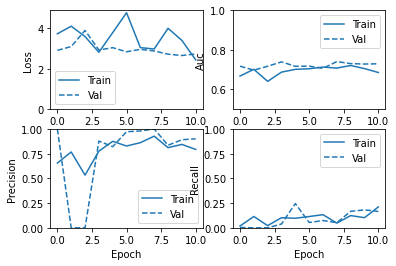

In [8]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# with open(outputFolder+"history.json", 'w') as fp:
# json.dumps(str(model.history) )
    
plot_metrics(model_history)

loss :  0.9248463586915897
accuracy :  0.4375
precision :  0.8929663896560669
recall :  0.17391304671764374
auc :  0.7330464720726013
[[0.20575932]
 [0.13916647]
 [0.23050835]
 ...
 [0.22644396]
 [0.00948846]
 [0.18387317]]


Legitimate Transactions Detected (True Negatives):  814
Legitimate Transactions Incorrectly Detected (False Positives):  35
Fraudulent Transactions Missed (False Negatives):  1387
Fraudulent Transactions Detected (True Positives):  292
Total Fraudulent Transactions:  1679


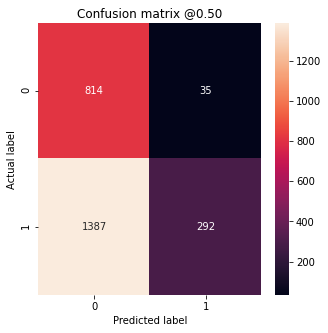

In [9]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_baseline = model.predict(val_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


baseline_results = model.evaluate(val_features, val_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
# print(test_predictions_baseline)

plot_cm(val_labels, val_predictions_baseline)

In [10]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#   plt.xlim([-0.5,20])
#   plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

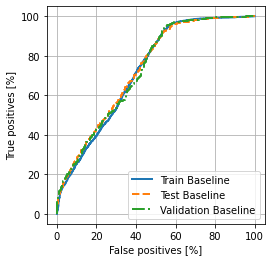

In [11]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
# plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plot_roc("Validation Baseline", val_labels, val_predictions_baseline, color=colors[2], linestyle='-.')

plt.legend(loc='lower right')

In [27]:
# print(val_predictions_baseline)
# print(val_predictions_baseline.shape)
# val_predictions_baseline.flatten()
# print(val_predictions_baseline.flatten())
# print(val_labels)
# # val_weights = np.array(val_df.copy('weight'))
# # val_weights = val_df['weight'].copy().values
# # print(val_weights)

# print(len(val_predictions_baseline.flatten()))
# print(len(val_labels))
# print(len(val_weights))

In [12]:
scoring.rejection90(val_labels, val_predictions_baseline.flatten(), sample_weight=val_weights)

0.559410189561211

In [0]:
# model.fit(train.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values, train.label, sample_weight=train.kinWeight.values)

In [13]:
# predictions = model.predict_proba(test.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


In [15]:

compression_opts = dict(method='zip',
                        archive_name='submission.csv')  
pd.DataFrame(data={"prediction": test_predictions.flatten()}, index=test_df.index).to_csv(
    "submission.zip", index_label=utils.ID_COLUMN, compression=compression_opts)

In [16]:
submission = pd.read_csv("./submission.zip")
submission.head(5)

,id,prediction
0,2362361,0.205759
1,343698,0.139166
2,5134561,0.230508
3,866551,0.260668
4,4970942,0.248825
